# Pulse Level Learning

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

For this notebook, we take all necessary inputs from the `pulse_config.py` file. This python file contains all elements necessary to create a pulse-level quantum environment. The file contains the following elements:
- a parametrized gate function, coded through Qiskit; leveraging behind the scenes a custom parametrized pulse schedule, to be inserted in the quantum circuit. The function needs to modify an input parametrized quantum circuit, by appending the parametrized gate to it.
- a Qiskit backend object, which is the quantum device or simulator on which the quantum circuits will be executed. The backend is retrieved through another template function called get_backend.
- A circuit context, which is a `QuantumCircuit` object that contains the quantum circuit in which the target gate operation should be optimized. The context is used to create the `ContextAwareQuantumEnvironment` object, which is a subclass of `BaseQuantumEnvironment` that takes into account the context of the quantum circuit in which the gate is to be optimized. Note that this mode is optional, as one could just focus on optimizing the gate operation in a standalone manner (i.e., without any context).

We provide a dedicated template for IBM devices working through ECR, X, and SX basis gates. The user can adapt this to the platform and basis gates of his choice.

In [1]:
%matplotlib inline

from pulse_level.qiskit_pulse.x_calibration.pulse_config import (
    apply_parametrized_circuit,
)
from rl_qoc import ContextAwareQuantumEnvironment, QuantumEnvironment, CustomPPO
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from rl_qoc.helpers import (
    simulate_pulse_input,
    load_from_yaml_file,
    get_q_env_config,
)
import numpy as np
import os
import matplotlib.pyplot as plt

# QuantumEnvironment setup
We first define our custom `DynamicsBackend` object describing our quantum system. We use some helper functions to create it and make our job easier

In [2]:
# Backend definition
from pulse_level.qiskit_pulse.dynamics_backends import fixed_frequency_transmon_backend
from rl_qoc.helpers import (
    perform_standard_calibrations,
    custom_experiment_result_function,
)

dims = [3]
freqs = [4.86e9]
anharmonicities = [-0.33e9]
rabi_freqs = [0.22e9]
couplings = None

backend = fixed_frequency_transmon_backend(
    dims,
    freqs,
    anharmonicities,
    rabi_freqs,
    couplings,
    experiment_result_function=custom_experiment_result_function,
    # Custom experiment result function returning the statevector on top of the original counts
)

# Add calibrations for standard single qubit basis gates (X, SX, RZ, and other phase gates)
cals, exps = perform_standard_calibrations(backend)
# Backend now contains the standard calibrations

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'delay', 's', 'measure', 'h', 'sdg', 't', 'sx', 'reset', 'x', 'z', 'tdg', 'rz', 'id'}
Multi qubit instructions:
)>


In [3]:
print(backend.target)

Target
Number of qubits: 1
Instructions:
	measure
		(0,):
			Duration: 2.222e-07 sec.
			Error Rate: 0
			With pulse schedule calibration
	z
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	s
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	id
		(0,):
			Duration: 4.444e-09 sec.
			Error Rate: 0
			With pulse schedule calibration
	h
		(0,):
			Duration: 3.5552e-08 sec.
			Error Rate: 0
			With pulse schedule calibration
	x
		(0,):
			Duration: 3.5552e-08 sec.
			Error Rate: 0
			With pulse schedule calibration
	sx
		(0,):
			Duration: 3.5552e-08 sec.
			Error Rate: 0
			With pulse schedule ca

In [4]:
current_dir = os.getcwd()
config_file_name = "q_env_pulse_config.yml"
config_file_address = os.path.join(current_dir, config_file_name)

q_env_config = get_q_env_config(
    config_file_address, apply_parametrized_circuit, backend
)

# Set the parametrized circuit kwargs to be used in the parametrized circuit function
q_env_config.backend_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}

We can define an optional circuit context in which we would like to calibrate the gate.
If the context is not provided, the gate will be calibrated in a standalone manner.

Note: If no context is provided, then the user should use the `QuantumEnvironment` class. Conversely, if a context is provided, the user should use the `ContextAwareQuantumEnvironment` class.

Circuit subject to calibration:


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/visualization/circuit/circuit_visualization.py:355: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  image.show()


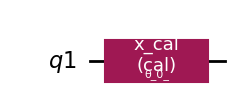

In [5]:
# Set the use_context flag to True if you want to use the context of the quantum circuit
# TODO: Fill up your circuit context
circuit_context = None

if circuit_context is not None:
    fig = circuit_context.draw("mpl", interactive=True)

    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )

else:
    q_env = QuantumEnvironment(q_env_config)
    fig = q_env.circuits[0].draw("mpl", interactive=True)

# Rescale the action space to [-1, 1] and clip the actions to the valid range
# This step is dependent on the output layer of the agent for the mean of the policy
# If the output layer is a tanh layer (default), then rescaling is necessary

rescaled_env = ClipAction(
    RescaleAction(q_env, q_env.action_space.low, q_env.action_space.high)
)

print("Circuit subject to calibration:")
fig

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_57362/1543346495.py:1: DeprecationWarning: The method ``qiskit.transpiler.target.Target.get_calibration()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.transpiler.target.Target.get_calibration()`` will have no alternative in Qiskit.
  q_env.backend.target.get_calibration("x", (0,)).draw()


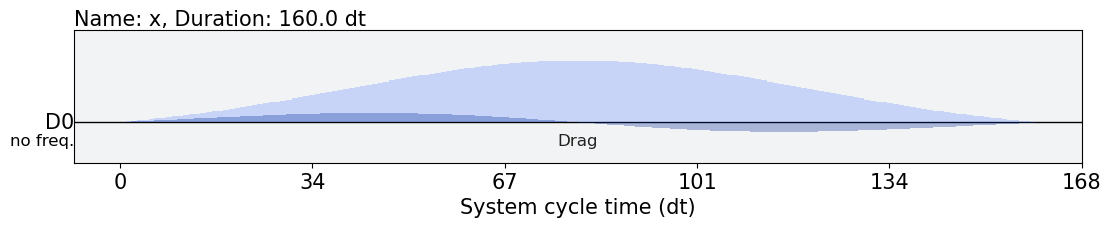

In [6]:
q_env.backend.target.get_calibration("x", (0,)).draw()

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_57362/3733329632.py:4: DeprecationWarning: The function ``qiskit.compiler.scheduler.schedule()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that ``qiskit.compiler.scheduler.schedule()`` will be moved as well.
  schedule(q_env.circuits[0], q_env.backend).draw()


Parametrized circuit


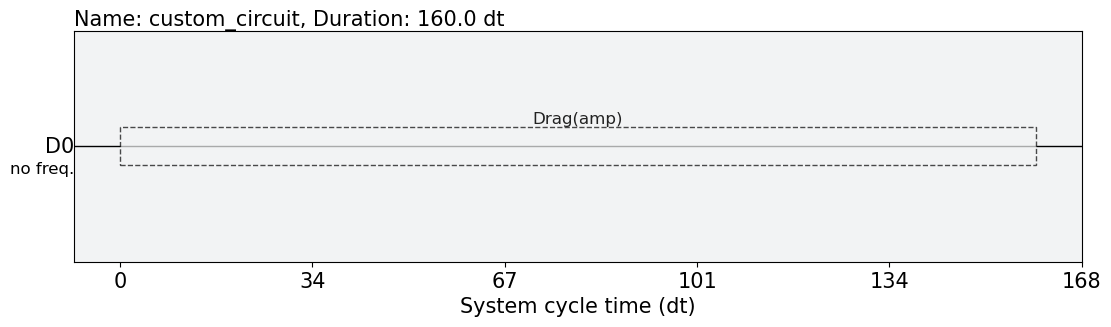

In [7]:
from qiskit import schedule

print("Parametrized circuit")
schedule(q_env.circuits[0], q_env.backend).draw()

In [8]:
from qiskit.visualization import plot_circuit_layout

print("Available operations", q_env.backend.operation_names)
try:
    plot_circuit_layout(circuit_context, backend=q_env.backend)
except:
    print("No layout available")

Available operations ['measure', 'z', 's', 'sdg', 't', 'tdg', 'rz', 'id', 'h', 'x', 'sx', 'reset', 'delay', 'switch_case', 'for_loop', 'if_else', 'while_loop', 'x_cal']
No layout available


# Agent setup

We now define the agent counterpart.

In [9]:
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd() / file_name

agent_config = load_from_yaml_file(file_location)

In [10]:
ppo_agent = CustomPPO(agent_config, rescaled_env)

In [11]:
from rl_qoc.agent import TotalUpdates, TrainFunctionSettings, TrainingConfig

total_updates = TotalUpdates(500)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=True,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True,
)

In [12]:
ppo_agent.agent_config.ent_coef = 0.01

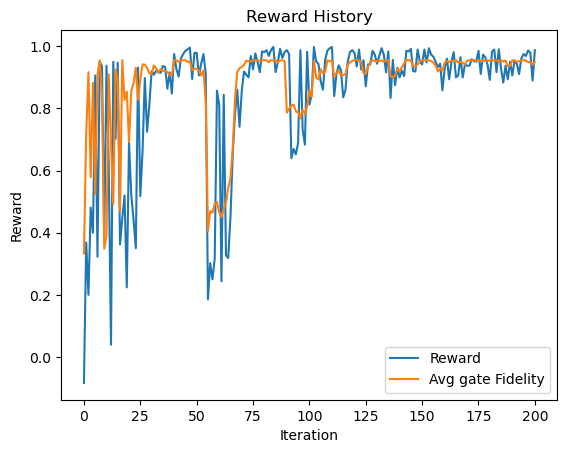


 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: 0.9555471430638273
Finished simulation benchmark
Hardware runtime taken: 0.0 hours  0.0008 min  0.046 seconds


{'avg_reward': [-0.08333333333333334,
  0.36875,
  0.2,
  0.48124999999999996,
  0.39999999999999997,
  0.9062500000000002,
  0.3229166666666667,
  0.9500000000000002,
  0.9355468750000002,
  0.3958333333333333,
  0.9375000000000002,
  0.6104166666666666,
  0.03958333333333331,
  0.9500000000000003,
  0.7020833333333335,
  0.9472656250000002,
  0.36249999999999993,
  0.44583333333333336,
  0.5195312500000002,
  0.22416666666666665,
  0.6895833333333333,
  0.5208333333333334,
  0.44166666666666665,
  0.3500000000000001,
  0.9312500000000001,
  0.517578125,
  0.6640625,
  0.8979166666666669,
  0.725,
  0.810546875,
  0.9208333333333336,
  0.9083333333333333,
  0.9208333333333336,
  0.9166666666666669,
  0.9145833333333335,
  0.9366666666666668,
  0.9333333333333336,
  0.86328125,
  0.916015625,
  0.8479166666666667,
  0.975,
  0.9270833333333336,
  0.9023437500000002,
  0.9604166666666668,
  0.9750000000000001,
  0.9854166666666668,
  0.9902343750000002,
  0.9958333333333333,
  0.8945312

<Figure size 640x480 with 0 Axes>

In [13]:
ppo_agent.train(
    training_config=training_config, train_function_settings=train_function_settings
)

In [14]:
import matplotlib.pyplot as plt

plt.plot(ppo_agent.training_results["std_action"])
plt.xlabel("Updates")
plt.ylabel("Standard Deviation of Actions")
plt.title("Standard Deviation of Actions during Training")

AttributeError: 'CustomPPO' object has no attribute '_training_results'

Text(0.5, 1.0, 'Actions during Training')

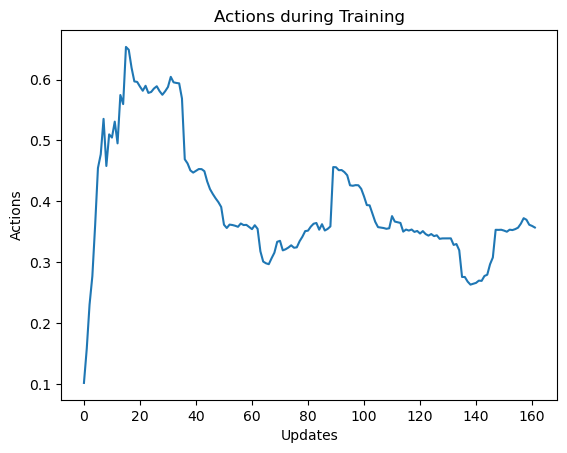

In [16]:
plt.plot(ppo_agent.training_results["action_history"])
plt.xlabel("Updates")
plt.ylabel("Actions")
plt.title("Actions during Training")

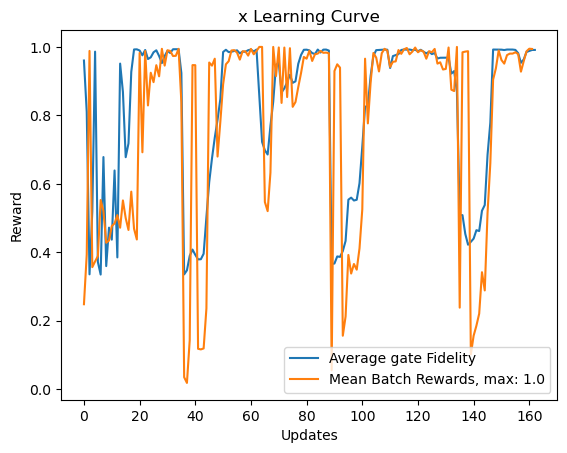

In [17]:
from rl_qoc import GateTarget

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
if q_env.benchmark_cycle != 0:
    fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
plt.plot(
    # fidelity_range,
    np.array(q_env.fidelity_history),
    label=f"Average {q_env.target.target_type} Fidelity",
)
plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")

plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name if isinstance(q_env.target, GateTarget) else ''} Learning Curve"
)
plt.legend()
plt.show()

In [16]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.fidelity_history))

Optimal action [0.56985503]
Best fidelity: 0.9895973280337157


In [17]:
initial_amp = (
    q_env.backend.target.get_calibration("x", (0,)).instructions[0][1].pulse.amp
)
initial_amp

0.11860954

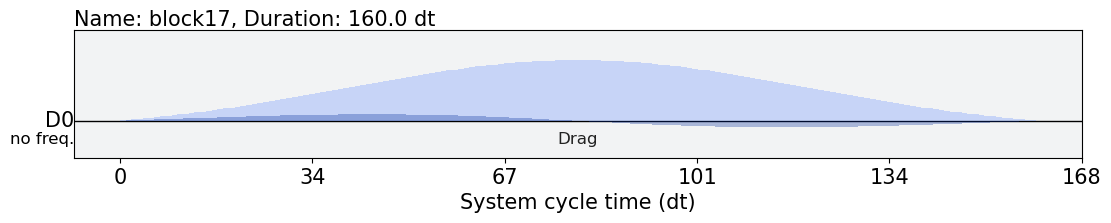

In [18]:
# Update calibration in the backend target and retrieve the calibration
optimal_calibration = q_env.update_gate_calibration()
optimal_calibration.draw()

Text(0.5, 1.0, 'Rabi experiment')

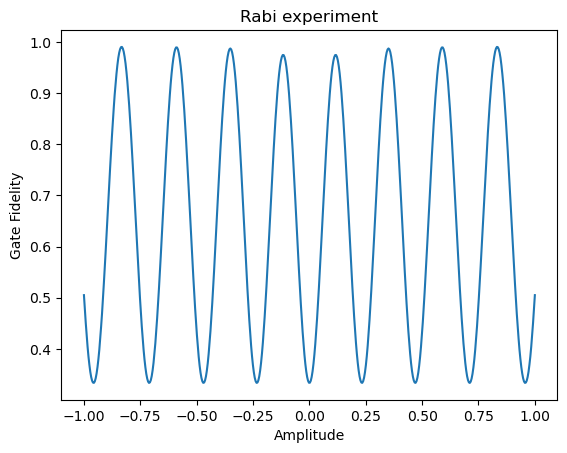

In [19]:
# Plot the fidelity as a function of the amplitude (for X gate)
from pulse_level.qiskit_pulse.x_calibration.pulse_config import custom_schedule

amp_range = np.linspace(-1, 1, 500)
fidelity_range = []
cals = []
for amp in amp_range:
    cal = custom_schedule(
        q_env.backend, q_env.physical_target_qubits, q_env.parameters
    ).assign_parameters({q_env.parameters: [amp]})
    cals.append(cal)
data = simulate_pulse_input(q_env.backend, cals, target=q_env.target.target_operator)
fidelity_range = data["gate_fidelity"]["raw"]
plt.plot(amp_range, fidelity_range)
plt.xlabel("Amplitude")
plt.ylabel("Gate Fidelity")
plt.title("Rabi experiment")

In [20]:
from qiskit.quantum_info import Operator, Statevector

data = simulate_pulse_input(
    q_env.backend,
    optimal_calibration,
    target=Operator(q_env.target.gate),
)

print(data)

{'unitary': Operator([[ 1.70592989e-01-2.22017979e-01j,
           -6.52423834e-01+7.04314410e-01j,
           -2.56815758e-03-4.08893444e-03j],
          [ 3.16557647e-01-9.06374494e-01j,
            1.16196868e-01-2.54746637e-01j,
           -2.31319746e-03+4.14062030e-03j],
          [-6.66962505e-05+4.50927961e-03j,
           -5.04321904e-03+1.87349001e-04j,
           -4.68543933e-01+8.83486407e-01j]],
         input_dims=(3,), output_dims=(3,)), 'state': DensityMatrix([[ 7.83939511e-02+1.10972552e-18j,
                 2.55233949e-01+8.43396455e-02j,
                -1.01251906e-03-7.54443723e-04j],
               [ 2.55233949e-01-8.43396455e-02j,
                 9.21723468e-01-2.48086177e-18j,
                -4.10820924e-03-1.36699516e-03j],
               [-1.01251906e-03+7.54443723e-04j,
                -4.10820924e-03+1.36699516e-03j,
                 2.03380510e-05+2.48121831e-23j]],
              dims=(3,)), 'projected_unitary': Operator([[ 0.17059299-0.22201798j, -0.822

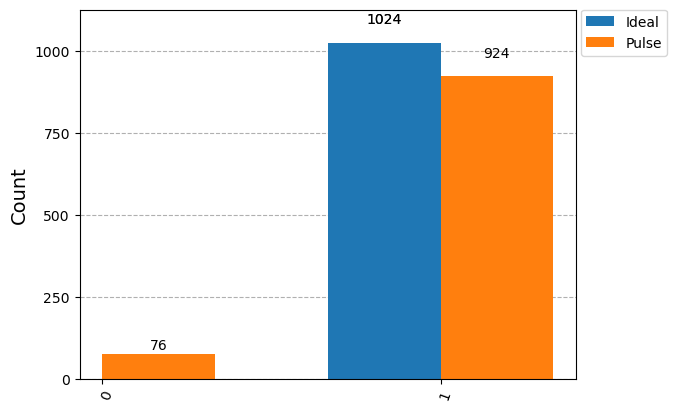

In [23]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(1)
qc.x(0)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 1000
pulse_results = q_env.backend.run(pulse_circ).result()

plot_histogram(
    [basic_result.get_counts(), pulse_results.get_counts()], legend=["Ideal", "Pulse"]
)

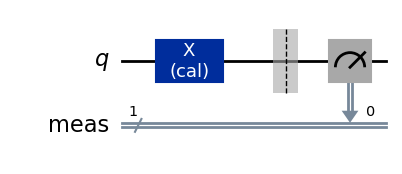

In [22]:
pulse_circ.draw("mpl")

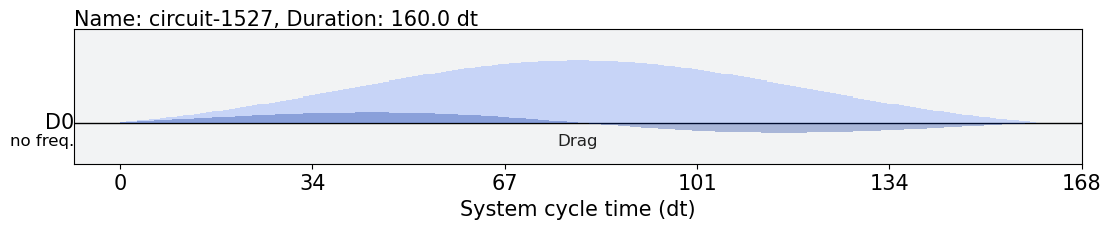

In [29]:
# Testing the pulse schedule
from qiskit import schedule

pulse_schedule = schedule(
    pulse_circ.remove_final_measurements(inplace=False), q_env.backend
)
pulse_schedule.draw()

In [31]:
# Testing the pulse schedule
pulse_sim_results = simulate_pulse_input(q_env.backend, pulse_circ)
print(pulse_sim_results)

IndexError: list index out of range